In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Path to your dataset
test_dataset_path = '/content/drive/MyDrive/cocoann'

dataset_path = '/content/drive/MyDrive/TestDataset'
pt='/content/drive/MyDrive/groundingdino_swint_ogc.pth'
config= '/content/drive/MyDrive/GroundingDINO_SwinT_OGC.py'

# COCO_ANNOTATION_PATH = "'/content/drive/MyDrive/cocoann/annotations/instances_default.json"
# IMAGE_DIR = "content/drive/MyDrive/cocoann/images"
# OUTPUT_JSON = "predictions.json"
# MODEL_ID = "IDEA-Research/grounding-dino-tiny"
# BOX_THRESHOLD = 0.3
# TEXT_THRESHOLD = 0.25

Mounted at /content/drive


In [9]:
import os
import json
import torch
from PIL import Image
from tqdm import tqdm
from transformers import AutoProcessor, GroundingDinoForObjectDetection

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval


# === CONFIG ===
ANNOTATIONS_PATH = "/content/drive/MyDrive/cocoann/annotations/instances_default.json"
IMAGE_DIR = "/content/drive/MyDrive/cocoann/images"
OUTPUT_JSON = "predictions_hf.json"
MODEL_ID = "IDEA-Research/grounding-dino-tiny"  # or use "grounding-dino-base"
BOX_THRESHOLD = 0.05
TEXT_THRESHOLD = 0.05
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === LOAD MODEL & PROCESSOR ===
print("Loading Hugging Face Grounding DINO model...")
processor = AutoProcessor.from_pretrained(MODEL_ID)
model = GroundingDinoForObjectDetection.from_pretrained(MODEL_ID).to(DEVICE)

# === LOAD COCO ANNOTATIONS ===
print("Loading COCO annotations...")
coco_gt = COCO(ANNOTATIONS_PATH)
categories = coco_gt.loadCats(coco_gt.getCatIds())
category_name_to_id = {cat["name"].lower(): cat["id"] for cat in categories}
class_names = list(category_name_to_id.keys())  # Use these as the prompt

# === INFERENCE LOOP ===
print("Running inference...")
results = []

for image_info in tqdm(coco_gt.dataset["images"]):
    image_id = image_info["id"]
    image_path = os.path.join(IMAGE_DIR, image_info["file_name"])
    image = Image.open(image_path).convert("RGB")

    # Preprocess input
    inputs = processor(
        images=image,
        text=", ".join(class_names),
        return_tensors="pt"
    ).to(DEVICE)

    # Model forward
    with torch.no_grad():
        outputs = model(**inputs)

    # Convert outputs to box predictions
    target_sizes = [image.size[::-1]]  # (height, width)
    results_processed = processor.post_process_grounded_object_detection(
        outputs,
        inputs.input_ids,
        box_threshold=BOX_THRESHOLD,
        text_threshold=TEXT_THRESHOLD,
        target_sizes=target_sizes
    )[0]
    print(f"→ boxes: {len(results_processed['boxes'])}, labels: {len(results_processed.get('text_labels', []))}")


    # Format predictions
    for box, label_text, score in zip(results_processed["boxes"], results_processed["text_labels"], results_processed["scores"]):
        label_clean = label_text.strip().lower()
        if label_text not in category_name_to_id:
            continue  # Skip unknown or unmatched labels

        x_min, y_min, x_max, y_max = box.tolist()
        width = x_max - x_min
        height = y_max - y_min

        results.append({
            "image_id": image_id,
            "category_id": category_name_to_id[label_text],
            "bbox": [x_min, y_min, width, height],
            "score": float(score)
        })
    print(f"[{image_info['file_name']}] Predictions:")
    for box, label_text, score in zip(
        results_processed["boxes"],
        results_processed["text_labels"],
        results_processed["scores"]):
        print(f"→ {label_text.strip().lower()}: {score:.2f}")




# === SAVE PREDICTIONS ===
with open(OUTPUT_JSON, "w") as f:
    json.dump(results, f)

# === EVALUATE USING COCO METRICS ===
print("Evaluating with COCO metrics...")
coco_dt = coco_gt.loadRes(OUTPUT_JSON)
evaluator = COCOeval(coco_gt, coco_dt, iouType="bbox")
evaluator.evaluate()
evaluator.accumulate()



Loading Hugging Face Grounding DINO model...
Loading COCO annotations...
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Running inference...


  1%|          | 1/95 [00:00<00:26,  3.49it/s]

→ boxes: 24, labels: 24
[clean_blank1.jpeg] Predictions:
→ trash, graffiti [sep]: 0.23
→ trash, graffiti [sep]: 0.18
→ trash graffiti: 0.13
→ trash, graffiti: 0.15
→ graffiti: 0.06
→ trash graffiti: 0.14
→ trash graffiti: 0.09
→ graffiti: 0.12
→ graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.05
→ trash graffiti: 0.06
→ graffiti: 0.05
→ trash graffiti: 0.08
→ graffiti: 0.07
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.06
→ trash graffiti: 0.07
→ graffiti: 0.05
→ trash: 0.05


  2%|▏         | 2/95 [00:00<00:27,  3.41it/s]

→ boxes: 28, labels: 28
[clean_blank10.jpg] Predictions:
→ trash, graffiti [sep]: 0.21
→ trash, graffiti: 0.16
→ trash graffiti: 0.13
→ graffiti: 0.07
→ graffiti: 0.09
→ graffiti: 0.08
→ trash graffiti: 0.11
→ graffiti: 0.09
→ graffiti: 0.05
→ graffiti: 0.07
→ graffiti: 0.07
→ trash graffiti: 0.10
→ trash graffiti: 0.10
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.05
→ trash, graffiti: 0.13
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.07
→ trash graffiti: 0.06
→ trash graffiti: 0.10
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.05


  3%|▎         | 3/95 [00:00<00:30,  3.04it/s]

→ boxes: 18, labels: 18
[clean_blank12.jpg] Predictions:
→ trash, graffiti [sep]: 0.17
→ trash graffiti: 0.12
→ trash graffiti [sep]: 0.16
→ trash graffiti: 0.09
→ graffiti: 0.10
→ trash graffiti: 0.11
→ trash graffiti: 0.12
→ trash graffiti: 0.08
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.06
→ trash, graffiti: 0.12
→ trash graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.07
→ trash graffiti: 0.09
→ graffiti: 0.05
→ graffiti: 0.05


  4%|▍         | 4/95 [00:01<00:31,  2.88it/s]

→ boxes: 26, labels: 26
[clean_blank13.jpg] Predictions:
→ trash, graffiti [sep]: 0.16
→ trash graffiti [sep]: 0.15
→ trash graffiti: 0.12
→ graffiti: 0.08
→ trash graffiti: 0.09
→ trash graffiti: 0.06
→ graffiti: 0.09
→ trash graffiti: 0.11
→ trash graffiti: 0.08
→ graffiti: 0.06
→ graffiti: 0.09
→ trash graffiti: 0.07
→ graffiti: 0.07
→ trash graffiti: 0.09
→ graffiti: 0.11
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.06
→ trash graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.06


  5%|▌         | 5/95 [00:01<00:32,  2.79it/s]

→ boxes: 22, labels: 22
[clean_blank16.jpg] Predictions:
→ trash, graffiti [sep]: 0.16
→ trash, graffiti [sep]: 0.17
→ trash graffiti: 0.11
→ trash graffiti: 0.09
→ trash graffiti: 0.14
→ graffiti: 0.06
→ trash, graffiti: 0.13
→ graffiti: 0.06
→ graffiti: 0.07
→ trash graffiti: 0.09
→ trash graffiti: 0.11
→ trash graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.08
→ graffiti: 0.07
→ graffiti: 0.07
→ graffiti: 0.07
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.06


  6%|▋         | 6/95 [00:01<00:29,  3.07it/s]

→ boxes: 25, labels: 25
[clean_blank19.jpg] Predictions:
→ trash graffiti: 0.11
→ trash graffiti: 0.15
→ trash graffiti: 0.15
→ graffiti: 0.10
→ trash graffiti: 0.13
→ trash graffiti: 0.12
→ graffiti: 0.09
→ trash graffiti: 0.12
→ graffiti: 0.08
→ graffiti: 0.08
→ trash graffiti: 0.09
→ trash graffiti: 0.08
→ trash, graffiti: 0.15
→ trash graffiti: 0.11
→ graffiti: 0.06
→ graffiti: 0.08
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.06
→ trash graffiti: 0.07
→ graffiti: 0.08
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.06


  7%|▋         | 7/95 [00:02<00:27,  3.23it/s]

→ boxes: 24, labels: 24
[clean_blank20.jpeg] Predictions:
→ trash, graffiti [sep]: 0.23
→ trash, graffiti [sep]: 0.18
→ trash graffiti: 0.13
→ trash, graffiti: 0.15
→ graffiti: 0.06
→ trash graffiti: 0.14
→ trash graffiti: 0.09
→ graffiti: 0.12
→ graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.05
→ trash graffiti: 0.06
→ graffiti: 0.05
→ trash graffiti: 0.08
→ graffiti: 0.07
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.06
→ trash graffiti: 0.07
→ graffiti: 0.05
→ trash: 0.05


  8%|▊         | 8/95 [00:02<00:28,  3.05it/s]

→ boxes: 18, labels: 18
[clean_blank23.jpg] Predictions:
→ trash, graffiti [sep]: 0.17
→ trash graffiti: 0.12
→ trash graffiti [sep]: 0.16
→ trash graffiti: 0.09
→ graffiti: 0.10
→ trash graffiti: 0.11
→ trash graffiti: 0.12
→ trash graffiti: 0.08
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.06
→ trash, graffiti: 0.12
→ trash graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.07
→ trash graffiti: 0.09
→ graffiti: 0.05
→ graffiti: 0.05


  9%|▉         | 9/95 [00:02<00:28,  3.03it/s]

→ boxes: 34, labels: 34
[clean_blank25.jpg] Predictions:
→ trash, graffiti [sep]: 0.20
→ graffiti: 0.11
→ graffiti: 0.12
→ graffiti: 0.12
→ graffiti: 0.08
→ graffiti: 0.12
→ trash graffiti: 0.12
→ trash graffiti: 0.07
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.07
→ trash graffiti: 0.09
→ graffiti: 0.07
→ trash graffiti: 0.06
→ graffiti: 0.07
→ trash graffiti: 0.08
→ graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.05
→ trash graffiti: 0.07
→ trash graffiti: 0.08
→ trash graffiti: 0.08
→ graffiti: 0.05
→ trash graffiti: 0.07
→ graffiti: 0.11
→ trash graffiti: 0.07
→ graffiti: 0.06
→ trash graffiti: 0.11
→ graffiti: 0.06
→ graffiti: 0.09
→ graffiti: 0.08
→ graffiti: 0.06
→ graffiti: 0.06


 11%|█         | 10/95 [00:03<00:26,  3.19it/s]

→ boxes: 24, labels: 24
[clean_blank26.jpeg] Predictions:
→ trash, graffiti [sep]: 0.23
→ trash, graffiti [sep]: 0.18
→ trash graffiti: 0.13
→ trash, graffiti: 0.15
→ graffiti: 0.06
→ trash graffiti: 0.14
→ trash graffiti: 0.09
→ graffiti: 0.12
→ graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.05
→ trash graffiti: 0.06
→ graffiti: 0.05
→ trash graffiti: 0.08
→ graffiti: 0.07
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.06
→ trash graffiti: 0.07
→ graffiti: 0.05
→ trash: 0.05


 12%|█▏        | 11/95 [00:03<00:27,  3.08it/s]

→ boxes: 12, labels: 12
[clean_blank27.jpg] Predictions:
→ trash graffiti: 0.16
→ trash, graffiti [sep]: 0.17
→ trash, graffiti [sep]: 0.17
→ trash, graffiti [sep]: 0.14
→ trash graffiti: 0.07
→ graffiti: 0.07
→ graffiti: 0.06
→ graffiti: 0.06
→ trash graffiti: 0.09
→ trash graffiti: 0.08
→ trash, graffiti: 0.12
→ graffiti: 0.05


 13%|█▎        | 12/95 [00:03<00:28,  2.94it/s]

→ boxes: 26, labels: 26
[clean_blank28.jpg] Predictions:
→ trash, graffiti [sep]: 0.16
→ trash graffiti [sep]: 0.15
→ trash graffiti: 0.12
→ graffiti: 0.08
→ trash graffiti: 0.09
→ trash graffiti: 0.06
→ graffiti: 0.09
→ trash graffiti: 0.11
→ trash graffiti: 0.08
→ graffiti: 0.06
→ graffiti: 0.09
→ trash graffiti: 0.07
→ graffiti: 0.07
→ trash graffiti: 0.09
→ graffiti: 0.11
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.06
→ trash graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.06


 14%|█▎        | 13/95 [00:04<00:28,  2.85it/s]

→ boxes: 22, labels: 22
[clean_blank29.jpg] Predictions:
→ trash, graffiti [sep]: 0.16
→ trash, graffiti [sep]: 0.17
→ trash graffiti: 0.11
→ trash graffiti: 0.09
→ trash graffiti: 0.14
→ graffiti: 0.06
→ trash, graffiti: 0.13
→ graffiti: 0.06
→ graffiti: 0.07
→ trash graffiti: 0.09
→ trash graffiti: 0.11
→ trash graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.08
→ graffiti: 0.07
→ graffiti: 0.07
→ graffiti: 0.07
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.06


 15%|█▍        | 14/95 [00:04<00:29,  2.78it/s]

→ boxes: 20, labels: 20
[clean_blank30.jpg] Predictions:
→ trash, graffiti [sep]: 0.21
→ trash, graffiti [sep]: 0.24
→ trash graffiti: 0.11
→ graffiti: 0.10
→ graffiti: 0.08
→ graffiti: 0.07
→ graffiti: 0.06
→ trash graffiti: 0.10
→ graffiti: 0.07
→ graffiti: 0.06
→ graffiti: 0.05
→ trash graffiti: 0.11
→ graffiti: 0.06
→ graffiti: 0.05
→ trash graffiti: 0.12
→ trash graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.07
→ graffiti: 0.06


 16%|█▌        | 15/95 [00:05<00:29,  2.75it/s]

→ boxes: 22, labels: 22
[clean_blank31.jpg] Predictions:
→ trash, graffiti [sep]: 0.16
→ trash, graffiti [sep]: 0.17
→ trash graffiti: 0.11
→ trash graffiti: 0.09
→ trash graffiti: 0.14
→ graffiti: 0.06
→ trash, graffiti: 0.13
→ graffiti: 0.06
→ graffiti: 0.07
→ trash graffiti: 0.09
→ trash graffiti: 0.11
→ trash graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.08
→ graffiti: 0.07
→ graffiti: 0.07
→ graffiti: 0.07
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.06


 17%|█▋        | 16/95 [00:05<00:28,  2.75it/s]

→ boxes: 19, labels: 19
[clean_blank32.jpg] Predictions:
→ trash graffiti: 0.18
→ trash, graffiti [sep]: 0.18
→ graffiti: 0.09
→ trash graffiti: 0.10
→ trash graffiti: 0.12
→ graffiti: 0.05
→ trash graffiti: 0.11
→ trash graffiti: 0.12
→ graffiti: 0.06
→ trash graffiti: 0.08
→ graffiti: 0.07
→ trash graffiti: 0.07
→ trash graffiti: 0.08
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.05


 18%|█▊        | 17/95 [00:05<00:27,  2.81it/s]

→ boxes: 29, labels: 29
[clean_blank33.jpg] Predictions:
→ trash, graffiti [sep]: 0.20
→ trash graffiti: 0.18
→ trash graffiti: 0.13
→ trash graffiti: 0.13
→ graffiti: 0.10
→ graffiti: 0.07
→ graffiti: 0.07
→ trash graffiti: 0.10
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.06
→ trash graffiti: 0.08
→ graffiti: 0.05
→ graffiti: 0.06
→ trash graffiti: 0.10
→ graffiti: 0.05
→ trash graffiti: 0.07
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.10
→ graffiti: 0.07
→ graffiti: 0.06
→ graffiti: 0.06


 19%|█▉        | 18/95 [00:06<00:24,  3.12it/s]

→ boxes: 29, labels: 29
[clean_blank34.jpeg] Predictions:
→ trash, graffiti: 0.20
→ trash graffiti: 0.10
→ trash graffiti: 0.10
→ trash graffiti: 0.14
→ trash graffiti: 0.12
→ trash graffiti: 0.07
→ graffiti: 0.09
→ trash graffiti: 0.09
→ trash graffiti: 0.10
→ graffiti: 0.06
→ graffiti: 0.08
→ graffiti: 0.08
→ trash graffiti: 0.09
→ trash graffiti: 0.09
→ graffiti: 0.09
→ trash graffiti: 0.08
→ trash graffiti: 0.09
→ graffiti: 0.08
→ graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.06


 20%|██        | 19/95 [00:06<00:25,  2.97it/s]

→ boxes: 18, labels: 18
[clean_blank35.jpg] Predictions:
→ trash, graffiti [sep]: 0.17
→ trash graffiti: 0.12
→ trash graffiti [sep]: 0.16
→ trash graffiti: 0.09
→ graffiti: 0.10
→ trash graffiti: 0.11
→ trash graffiti: 0.12
→ trash graffiti: 0.08
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.06
→ trash, graffiti: 0.12
→ trash graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.07
→ trash graffiti: 0.09
→ graffiti: 0.05
→ graffiti: 0.05


 21%|██        | 20/95 [00:06<00:22,  3.26it/s]

→ boxes: 29, labels: 29
[clean_blank36.jpeg] Predictions:
→ trash, graffiti: 0.20
→ trash graffiti: 0.10
→ trash graffiti: 0.10
→ trash graffiti: 0.14
→ trash graffiti: 0.12
→ trash graffiti: 0.07
→ graffiti: 0.09
→ trash graffiti: 0.09
→ trash graffiti: 0.10
→ graffiti: 0.06
→ graffiti: 0.08
→ graffiti: 0.08
→ trash graffiti: 0.09
→ trash graffiti: 0.09
→ graffiti: 0.09
→ trash graffiti: 0.08
→ trash graffiti: 0.09
→ graffiti: 0.08
→ graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.06


 22%|██▏       | 21/95 [00:06<00:23,  3.20it/s]

→ boxes: 34, labels: 34
[clean_blank37.jpg] Predictions:
→ trash, graffiti [sep]: 0.20
→ graffiti: 0.11
→ graffiti: 0.12
→ graffiti: 0.12
→ graffiti: 0.08
→ graffiti: 0.12
→ trash graffiti: 0.12
→ trash graffiti: 0.07
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.07
→ trash graffiti: 0.09
→ graffiti: 0.07
→ trash graffiti: 0.06
→ graffiti: 0.07
→ trash graffiti: 0.08
→ graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.05
→ trash graffiti: 0.07
→ trash graffiti: 0.08
→ trash graffiti: 0.08
→ graffiti: 0.05
→ trash graffiti: 0.07
→ graffiti: 0.11
→ trash graffiti: 0.07
→ graffiti: 0.06
→ trash graffiti: 0.11
→ graffiti: 0.06
→ graffiti: 0.09
→ graffiti: 0.08
→ graffiti: 0.06
→ graffiti: 0.06


 23%|██▎       | 22/95 [00:07<00:22,  3.25it/s]

→ boxes: 28, labels: 28
[clean_blank38.jpg] Predictions:
→ trash, graffiti [sep]: 0.21
→ trash, graffiti: 0.16
→ trash graffiti: 0.13
→ graffiti: 0.07
→ graffiti: 0.09
→ graffiti: 0.08
→ trash graffiti: 0.11
→ graffiti: 0.09
→ graffiti: 0.05
→ graffiti: 0.07
→ graffiti: 0.07
→ trash graffiti: 0.10
→ trash graffiti: 0.10
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.05
→ trash, graffiti: 0.13
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.07
→ trash graffiti: 0.06
→ trash graffiti: 0.10
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.05


 24%|██▍       | 23/95 [00:07<00:21,  3.42it/s]

→ boxes: 25, labels: 25
[clean_blank39.jpg] Predictions:
→ trash graffiti: 0.11
→ trash graffiti: 0.15
→ trash graffiti: 0.15
→ graffiti: 0.10
→ trash graffiti: 0.13
→ trash graffiti: 0.12
→ graffiti: 0.09
→ trash graffiti: 0.12
→ graffiti: 0.08
→ graffiti: 0.08
→ trash graffiti: 0.09
→ trash graffiti: 0.08
→ trash, graffiti: 0.15
→ trash graffiti: 0.11
→ graffiti: 0.06
→ graffiti: 0.08
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.06
→ trash graffiti: 0.07
→ graffiti: 0.08
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.06


 25%|██▌       | 24/95 [00:07<00:20,  3.41it/s]

→ boxes: 28, labels: 28
[clean_blank40.jpg] Predictions:
→ trash, graffiti [sep]: 0.21
→ trash, graffiti: 0.16
→ trash graffiti: 0.13
→ graffiti: 0.07
→ graffiti: 0.09
→ graffiti: 0.08
→ trash graffiti: 0.11
→ graffiti: 0.09
→ graffiti: 0.05
→ graffiti: 0.07
→ graffiti: 0.07
→ trash graffiti: 0.10
→ trash graffiti: 0.10
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.05
→ trash, graffiti: 0.13
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.07
→ trash graffiti: 0.06
→ trash graffiti: 0.10
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.05


 26%|██▋       | 25/95 [00:08<00:20,  3.44it/s]

→ boxes: 30, labels: 30
[clean_blank41.jpg] Predictions:
→ trash, graffiti [sep]: 0.23
→ trash, graffiti: 0.16
→ trash graffiti: 0.16
→ graffiti: 0.10
→ trash graffiti: 0.13
→ graffiti: 0.10
→ trash, graffiti: 0.14
→ trash graffiti: 0.10
→ trash graffiti: 0.09
→ graffiti: 0.10
→ trash graffiti: 0.08
→ trash graffiti: 0.07
→ trash graffiti: 0.09
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.08
→ graffiti: 0.07
→ graffiti: 0.07
→ graffiti: 0.08
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.05
→ trash graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.09
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.08
→ graffiti: 0.06


 27%|██▋       | 26/95 [00:08<00:21,  3.28it/s]

→ boxes: 12, labels: 12
[clean_blank43.jpg] Predictions:
→ trash graffiti: 0.16
→ trash, graffiti [sep]: 0.17
→ trash, graffiti [sep]: 0.17
→ trash, graffiti [sep]: 0.14
→ trash graffiti: 0.07
→ graffiti: 0.07
→ graffiti: 0.06
→ graffiti: 0.06
→ trash graffiti: 0.09
→ trash graffiti: 0.08
→ trash, graffiti: 0.12
→ graffiti: 0.05


 28%|██▊       | 27/95 [00:08<00:22,  3.08it/s]

→ boxes: 26, labels: 26
[clean_blank44.jpg] Predictions:
→ trash, graffiti [sep]: 0.16
→ trash graffiti [sep]: 0.15
→ trash graffiti: 0.12
→ graffiti: 0.08
→ trash graffiti: 0.09
→ trash graffiti: 0.06
→ graffiti: 0.09
→ trash graffiti: 0.11
→ trash graffiti: 0.08
→ graffiti: 0.06
→ graffiti: 0.09
→ trash graffiti: 0.07
→ graffiti: 0.07
→ trash graffiti: 0.09
→ graffiti: 0.11
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.06
→ trash graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.06


 29%|██▉       | 28/95 [00:09<00:21,  3.05it/s]

→ boxes: 29, labels: 29
[clean_blank45.jpg] Predictions:
→ trash, graffiti [sep]: 0.20
→ trash graffiti: 0.18
→ trash graffiti: 0.13
→ trash graffiti: 0.13
→ graffiti: 0.10
→ graffiti: 0.07
→ graffiti: 0.07
→ trash graffiti: 0.10
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.06
→ trash graffiti: 0.08
→ graffiti: 0.05
→ graffiti: 0.06
→ trash graffiti: 0.10
→ graffiti: 0.05
→ trash graffiti: 0.07
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.10
→ graffiti: 0.07
→ graffiti: 0.06
→ graffiti: 0.06


 31%|███       | 29/95 [00:09<00:22,  2.94it/s]

→ boxes: 20, labels: 20
[clean_blank46.jpg] Predictions:
→ trash, graffiti [sep]: 0.21
→ trash, graffiti [sep]: 0.24
→ trash graffiti: 0.11
→ graffiti: 0.10
→ graffiti: 0.08
→ graffiti: 0.07
→ graffiti: 0.06
→ trash graffiti: 0.10
→ graffiti: 0.07
→ graffiti: 0.06
→ graffiti: 0.05
→ trash graffiti: 0.11
→ graffiti: 0.06
→ graffiti: 0.05
→ trash graffiti: 0.12
→ trash graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.07
→ graffiti: 0.06


 32%|███▏      | 30/95 [00:09<00:20,  3.16it/s]

→ boxes: 25, labels: 25
[clean_blank47.jpg] Predictions:
→ trash graffiti: 0.11
→ trash graffiti: 0.15
→ trash graffiti: 0.15
→ graffiti: 0.10
→ trash graffiti: 0.13
→ trash graffiti: 0.12
→ graffiti: 0.09
→ trash graffiti: 0.12
→ graffiti: 0.08
→ graffiti: 0.08
→ trash graffiti: 0.09
→ trash graffiti: 0.08
→ trash, graffiti: 0.15
→ trash graffiti: 0.11
→ graffiti: 0.06
→ graffiti: 0.08
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.06
→ trash graffiti: 0.07
→ graffiti: 0.08
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.06


 33%|███▎      | 31/95 [00:10<00:20,  3.06it/s]

→ boxes: 19, labels: 19
[clean_blank48.jpg] Predictions:
→ trash graffiti: 0.18
→ trash, graffiti [sep]: 0.18
→ graffiti: 0.09
→ trash graffiti: 0.10
→ trash graffiti: 0.12
→ graffiti: 0.05
→ trash graffiti: 0.11
→ trash graffiti: 0.12
→ graffiti: 0.06
→ trash graffiti: 0.08
→ graffiti: 0.07
→ trash graffiti: 0.07
→ trash graffiti: 0.08
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.05


 34%|███▎      | 32/95 [00:10<00:19,  3.15it/s]

→ boxes: 30, labels: 30
[clean_blank49.jpg] Predictions:
→ trash, graffiti [sep]: 0.23
→ trash, graffiti: 0.16
→ trash graffiti: 0.16
→ graffiti: 0.10
→ trash graffiti: 0.13
→ graffiti: 0.10
→ trash, graffiti: 0.14
→ trash graffiti: 0.10
→ trash graffiti: 0.09
→ graffiti: 0.10
→ trash graffiti: 0.08
→ trash graffiti: 0.07
→ trash graffiti: 0.09
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.08
→ graffiti: 0.07
→ graffiti: 0.07
→ graffiti: 0.08
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.05
→ trash graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.09
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.08
→ graffiti: 0.06


 35%|███▍      | 33/95 [00:10<00:19,  3.13it/s]

→ boxes: 34, labels: 34
[clean_blank50.jpg] Predictions:
→ trash, graffiti [sep]: 0.20
→ graffiti: 0.11
→ graffiti: 0.12
→ graffiti: 0.12
→ graffiti: 0.08
→ graffiti: 0.12
→ trash graffiti: 0.12
→ trash graffiti: 0.07
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.07
→ trash graffiti: 0.09
→ graffiti: 0.07
→ trash graffiti: 0.06
→ graffiti: 0.07
→ trash graffiti: 0.08
→ graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.05
→ trash graffiti: 0.07
→ trash graffiti: 0.08
→ trash graffiti: 0.08
→ graffiti: 0.05
→ trash graffiti: 0.07
→ graffiti: 0.11
→ trash graffiti: 0.07
→ graffiti: 0.06
→ trash graffiti: 0.11
→ graffiti: 0.06
→ graffiti: 0.09
→ graffiti: 0.08
→ graffiti: 0.06
→ graffiti: 0.06


 36%|███▌      | 34/95 [00:11<00:19,  3.12it/s]

→ boxes: 29, labels: 29
[clean_blank51.jpg] Predictions:
→ trash, graffiti [sep]: 0.20
→ trash graffiti: 0.18
→ trash graffiti: 0.13
→ trash graffiti: 0.13
→ graffiti: 0.10
→ graffiti: 0.07
→ graffiti: 0.07
→ trash graffiti: 0.10
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.06
→ trash graffiti: 0.08
→ graffiti: 0.05
→ graffiti: 0.06
→ trash graffiti: 0.10
→ graffiti: 0.05
→ trash graffiti: 0.07
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.10
→ graffiti: 0.07
→ graffiti: 0.06
→ graffiti: 0.06


 37%|███▋      | 35/95 [00:11<00:20,  2.99it/s]

→ boxes: 20, labels: 20
[clean_blank52.jpg] Predictions:
→ trash, graffiti [sep]: 0.21
→ trash, graffiti [sep]: 0.24
→ trash graffiti: 0.11
→ graffiti: 0.10
→ graffiti: 0.08
→ graffiti: 0.07
→ graffiti: 0.06
→ trash graffiti: 0.10
→ graffiti: 0.07
→ graffiti: 0.06
→ graffiti: 0.05
→ trash graffiti: 0.11
→ graffiti: 0.06
→ graffiti: 0.05
→ trash graffiti: 0.12
→ trash graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.07
→ graffiti: 0.06


 38%|███▊      | 36/95 [00:11<00:20,  2.92it/s]

→ boxes: 19, labels: 19
[clean_blank6.jpg] Predictions:
→ trash graffiti: 0.18
→ trash, graffiti [sep]: 0.18
→ graffiti: 0.09
→ trash graffiti: 0.10
→ trash graffiti: 0.12
→ graffiti: 0.05
→ trash graffiti: 0.11
→ trash graffiti: 0.12
→ graffiti: 0.06
→ trash graffiti: 0.08
→ graffiti: 0.07
→ trash graffiti: 0.07
→ trash graffiti: 0.08
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.05


 39%|███▉      | 37/95 [00:12<00:20,  2.83it/s]

→ boxes: 31, labels: 31
[grafi_1.jpg] Predictions:
→ trash graffiti: 0.15
→ trash, graffiti [sep]: 0.16
→ trash graffiti: 0.12
→ trash graffiti: 0.10
→ trash graffiti: 0.13
→ graffiti: 0.10
→ trash, graffiti [sep]: 0.17
→ graffiti: 0.12
→ graffiti: 0.06
→ trash graffiti: 0.09
→ graffiti: 0.07
→ graffiti: 0.07
→ trash graffiti: 0.08
→ trash graffiti: 0.09
→ graffiti: 0.07
→ graffiti: 0.06
→ trash graffiti: 0.09
→ trash graffiti: 0.07
→ graffiti: 0.06
→ graffiti: 0.07
→ graffiti: 0.08
→ graffiti: 0.05
→ trash graffiti: 0.08
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.06


 40%|████      | 38/95 [00:12<00:19,  2.90it/s]

→ boxes: 24, labels: 24
[grafi_10.jpg] Predictions:
→ trash, graffiti [sep]: 0.21
→ trash graffiti: 0.14
→ trash graffiti: 0.11
→ trash graffiti: 0.11
→ trash graffiti: 0.15
→ trash graffiti: 0.10
→ graffiti: 0.07
→ graffiti: 0.06
→ trash graffiti: 0.08
→ graffiti: 0.07
→ trash graffiti: 0.09
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.06


 41%|████      | 39/95 [00:12<00:19,  2.92it/s]

→ boxes: 24, labels: 24
[grafi_11.jpg] Predictions:
→ trash, graffiti [sep]: 0.21
→ trash graffiti: 0.14
→ trash graffiti: 0.11
→ trash graffiti: 0.11
→ trash graffiti: 0.15
→ trash graffiti: 0.10
→ graffiti: 0.07
→ graffiti: 0.06
→ trash graffiti: 0.08
→ graffiti: 0.07
→ trash graffiti: 0.09
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.06


 42%|████▏     | 40/95 [00:13<00:19,  2.79it/s]

→ boxes: 29, labels: 29
[grafi_12.jpg] Predictions:
→ trash graffiti: 0.14
→ trash graffiti: 0.13
→ graffiti: 0.07
→ trash graffiti: 0.11
→ graffiti: 0.05
→ trash graffiti: 0.09
→ trash graffiti: 0.09
→ graffiti: 0.08
→ trash graffiti: 0.07
→ graffiti: 0.07
→ graffiti: 0.07
→ graffiti: 0.10
→ graffiti: 0.06
→ graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.11
→ graffiti: 0.06
→ graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.07
→ graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.05


 43%|████▎     | 41/95 [00:13<00:19,  2.77it/s]

→ boxes: 26, labels: 26
[grafi_13.jpg] Predictions:
→ graffiti: 0.16
→ trash graffiti: 0.14
→ trash graffiti: 0.11
→ trash graffiti: 0.12
→ graffiti: 0.11
→ trash, graffiti [sep]: 0.17
→ trash graffiti: 0.10
→ graffiti: 0.06
→ graffiti: 0.07
→ trash graffiti: 0.10
→ trash graffiti: 0.08
→ graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.08
→ graffiti: 0.06
→ graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.09
→ graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.07
→ graffiti: 0.06
→ graffiti: 0.05


 44%|████▍     | 42/95 [00:13<00:19,  2.77it/s]

→ boxes: 26, labels: 26
[grafi_14.jpg] Predictions:
→ trash graffiti [sep]: 0.17
→ trash, graffiti [sep]: 0.15
→ trash graffiti: 0.11
→ trash graffiti: 0.12
→ trash, graffiti: 0.14
→ trash graffiti: 0.12
→ trash graffiti: 0.11
→ graffiti: 0.07
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.07
→ graffiti: 0.06
→ trash graffiti: 0.07
→ trash graffiti: 0.07
→ graffiti: 0.06
→ trash graffiti: 0.07
→ trash graffiti: 0.08
→ graffiti: 0.06
→ trash graffiti: 0.11
→ trash graffiti: 0.08
→ graffiti: 0.06
→ trash graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.06
→ trash graffiti: 0.08
→ trash graffiti: 0.07


 45%|████▌     | 43/95 [00:14<00:18,  2.74it/s]

→ boxes: 33, labels: 33
[grafi_15.jpg] Predictions:
→ trash, graffiti [sep]: 0.17
→ trash graffiti: 0.09
→ trash graffiti: 0.12
→ trash graffiti: 0.11
→ trash graffiti: 0.09
→ trash graffiti: 0.07
→ trash graffiti: 0.15
→ trash graffiti: 0.09
→ trash graffiti: 0.12
→ trash graffiti: 0.08
→ trash graffiti: 0.09
→ trash graffiti: 0.09
→ graffiti: 0.07
→ trash graffiti: 0.07
→ graffiti: 0.07
→ trash graffiti: 0.08
→ graffiti: 0.05
→ trash graffiti: 0.08
→ trash graffiti: 0.08
→ graffiti: 0.06
→ trash graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.06
→ trash graffiti: 0.07
→ graffiti: 0.06
→ graffiti: 0.07
→ trash graffiti: 0.06
→ graffiti: 0.05
→ trash graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.05


 46%|████▋     | 44/95 [00:14<00:16,  3.07it/s]

→ boxes: 16, labels: 16
[grafi_16.jpg] Predictions:
→ trash, graffiti: 0.20
→ graffiti: 0.05
→ trash graffiti: 0.15
→ trash graffiti: 0.08
→ graffiti: 0.05
→ trash graffiti: 0.09
→ trash graffiti: 0.06
→ trash graffiti: 0.07
→ trash graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.05
→ trash graffiti: 0.08
→ trash graffiti: 0.07
→ trash graffiti: 0.05
→ graffiti: 0.05


 47%|████▋     | 45/95 [00:14<00:15,  3.13it/s]

→ boxes: 15, labels: 15
[grafi_17.jpg] Predictions:
→ trash, graffiti [sep]: 0.22
→ trash graffiti: 0.15
→ trash graffiti: 0.13
→ trash graffiti: 0.10
→ graffiti: 0.07
→ graffiti: 0.05
→ trash graffiti: 0.11
→ graffiti: 0.05
→ trash graffiti: 0.09
→ graffiti: 0.07
→ trash graffiti: 0.07
→ trash graffiti: 0.07
→ graffiti: 0.06
→ trash graffiti: 0.08
→ graffiti: 0.06


 48%|████▊     | 46/95 [00:15<00:16,  3.00it/s]

→ boxes: 29, labels: 29
[grafi_18.jpg] Predictions:
→ trash graffiti: 0.14
→ trash graffiti: 0.13
→ graffiti: 0.07
→ trash graffiti: 0.11
→ graffiti: 0.05
→ trash graffiti: 0.09
→ trash graffiti: 0.09
→ graffiti: 0.08
→ trash graffiti: 0.07
→ graffiti: 0.07
→ graffiti: 0.07
→ graffiti: 0.10
→ graffiti: 0.06
→ graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.11
→ graffiti: 0.06
→ graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.07
→ graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.05


 49%|████▉     | 47/95 [00:15<00:16,  2.92it/s]

→ boxes: 27, labels: 27
[grafi_19.jpg] Predictions:
→ trash, graffiti [sep]: 0.21
→ graffiti: 0.08
→ graffiti: 0.08
→ trash graffiti: 0.11
→ trash, graffiti: 0.15
→ graffiti: 0.09
→ graffiti: 0.07
→ graffiti: 0.08
→ graffiti: 0.08
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.08
→ graffiti: 0.06
→ trash graffiti: 0.08
→ trash graffiti: 0.10
→ graffiti: 0.06
→ graffiti: 0.06
→ trash graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.07
→ graffiti: 0.06
→ graffiti: 0.06


 51%|█████     | 48/95 [00:15<00:14,  3.25it/s]

→ boxes: 16, labels: 16
[grafi_2.jpg] Predictions:
→ trash, graffiti: 0.20
→ graffiti: 0.05
→ trash graffiti: 0.15
→ trash graffiti: 0.08
→ graffiti: 0.05
→ trash graffiti: 0.09
→ trash graffiti: 0.06
→ trash graffiti: 0.07
→ trash graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.05
→ trash graffiti: 0.08
→ trash graffiti: 0.07
→ trash graffiti: 0.05
→ graffiti: 0.05


 52%|█████▏    | 49/95 [00:16<00:15,  3.03it/s]

→ boxes: 31, labels: 31
[grafi_20.jpg] Predictions:
→ trash graffiti: 0.15
→ trash, graffiti [sep]: 0.16
→ trash graffiti: 0.12
→ trash graffiti: 0.10
→ trash graffiti: 0.13
→ graffiti: 0.10
→ trash, graffiti [sep]: 0.17
→ graffiti: 0.12
→ graffiti: 0.06
→ trash graffiti: 0.09
→ graffiti: 0.07
→ graffiti: 0.07
→ trash graffiti: 0.08
→ trash graffiti: 0.09
→ graffiti: 0.07
→ graffiti: 0.06
→ trash graffiti: 0.09
→ trash graffiti: 0.07
→ graffiti: 0.06
→ graffiti: 0.07
→ graffiti: 0.08
→ graffiti: 0.05
→ trash graffiti: 0.08
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.06


 53%|█████▎    | 50/95 [00:16<00:17,  2.59it/s]

→ boxes: 44, labels: 44
[grafi_22.jpg] Predictions:
→ trash graffiti: 0.17
→ trash, graffiti [sep]: 0.18
→ trash graffiti: 0.14
→ trash graffiti: 0.07
→ trash graffiti: 0.15
→ graffiti: 0.11
→ trash graffiti: 0.10
→ graffiti: 0.10
→ graffiti: 0.06
→ trash graffiti: 0.10
→ trash graffiti: 0.09
→ graffiti: 0.07
→ graffiti: 0.09
→ trash graffiti: 0.10
→ graffiti: 0.10
→ graffiti: 0.08
→ graffiti: 0.08
→ graffiti: 0.07
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.07
→ trash graffiti: 0.06
→ graffiti: 0.07
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.08
→ graffiti: 0.05
→ graffiti: 0.06
→ trash graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.06


 54%|█████▎    | 51/95 [00:17<00:15,  2.75it/s]

→ boxes: 14, labels: 14
[grafi_23.jpg] Predictions:
→ trash, graffiti [sep]: 0.21
→ trash graffiti: 0.14
→ graffiti: 0.08
→ trash graffiti: 0.08
→ graffiti: 0.06
→ graffiti: 0.08
→ graffiti: 0.06
→ graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.05


 55%|█████▍    | 52/95 [00:17<00:15,  2.71it/s]

→ boxes: 29, labels: 29
[grafi_24.jpg] Predictions:
→ trash graffiti: 0.14
→ trash graffiti: 0.13
→ graffiti: 0.07
→ trash graffiti: 0.11
→ graffiti: 0.05
→ trash graffiti: 0.09
→ trash graffiti: 0.09
→ graffiti: 0.08
→ trash graffiti: 0.07
→ graffiti: 0.07
→ graffiti: 0.07
→ graffiti: 0.10
→ graffiti: 0.06
→ graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.11
→ graffiti: 0.06
→ graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.07
→ graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.05


 56%|█████▌    | 53/95 [00:17<00:17,  2.38it/s]

→ boxes: 21, labels: 21
[grafi_25.jpg] Predictions:
→ trash, graffiti [sep]: 0.23
→ trash graffiti: 0.09
→ trash graffiti: 0.12
→ graffiti: 0.07
→ trash graffiti: 0.09
→ graffiti: 0.10
→ graffiti: 0.08
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.10
→ trash graffiti: 0.08
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.05
→ trash graffiti: 0.11
→ trash graffiti: 0.08
→ graffiti: 0.06
→ graffiti: 0.05
→ trash, graffiti: 0.12


 57%|█████▋    | 54/95 [00:18<00:18,  2.19it/s]

→ boxes: 35, labels: 35
[grafi_26.jpg] Predictions:
→ trash, graffiti [sep]: 0.23
→ trash graffiti: 0.16
→ trash, graffiti [sep]: 0.25
→ trash graffiti: 0.14
→ trash graffiti: 0.12
→ trash graffiti: 0.10
→ trash graffiti: 0.13
→ trash graffiti: 0.06
→ graffiti: 0.09
→ graffiti: 0.07
→ trash graffiti: 0.11
→ graffiti: 0.06
→ graffiti: 0.06
→ trash graffiti: 0.11
→ graffiti: 0.07
→ graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.06
→ trash graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.07
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.06
→ trash graffiti: 0.07
→ graffiti: 0.07
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.12


 58%|█████▊    | 55/95 [00:19<00:19,  2.10it/s]

→ boxes: 21, labels: 21
[grafi_29.jpg] Predictions:
→ trash, graffiti [sep]: 0.23
→ trash graffiti: 0.09
→ trash graffiti: 0.12
→ graffiti: 0.07
→ trash graffiti: 0.09
→ graffiti: 0.10
→ graffiti: 0.08
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.10
→ trash graffiti: 0.08
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.05
→ trash graffiti: 0.11
→ trash graffiti: 0.08
→ graffiti: 0.06
→ graffiti: 0.05
→ trash, graffiti: 0.12


 59%|█████▉    | 56/95 [00:19<00:17,  2.25it/s]

→ boxes: 33, labels: 33
[grafi_3.jpg] Predictions:
→ trash, graffiti [sep]: 0.17
→ trash graffiti: 0.09
→ trash graffiti: 0.12
→ trash graffiti: 0.11
→ trash graffiti: 0.09
→ trash graffiti: 0.07
→ trash graffiti: 0.15
→ trash graffiti: 0.09
→ trash graffiti: 0.12
→ trash graffiti: 0.08
→ trash graffiti: 0.09
→ trash graffiti: 0.09
→ graffiti: 0.07
→ trash graffiti: 0.07
→ graffiti: 0.07
→ trash graffiti: 0.08
→ graffiti: 0.05
→ trash graffiti: 0.08
→ trash graffiti: 0.08
→ graffiti: 0.06
→ trash graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.06
→ trash graffiti: 0.07
→ graffiti: 0.06
→ graffiti: 0.07
→ trash graffiti: 0.06
→ graffiti: 0.05
→ trash graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.05


 60%|██████    | 57/95 [00:19<00:18,  2.10it/s]

→ boxes: 32, labels: 32
[grafi_30.jpg] Predictions:
→ trash, graffiti [sep]: 0.24
→ trash graffiti: 0.08
→ graffiti: 0.09
→ trash graffiti: 0.14
→ graffiti: 0.11
→ trash graffiti: 0.17
→ graffiti: 0.11
→ trash graffiti: 0.12
→ graffiti: 0.09
→ graffiti: 0.08
→ trash graffiti: 0.11
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.07
→ graffiti: 0.07
→ graffiti: 0.06
→ graffiti: 0.07
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.05
→ trash graffiti: 0.17
→ graffiti: 0.08
→ graffiti: 0.05
→ graffiti: 0.10
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.05


 61%|██████    | 58/95 [00:20<00:18,  2.03it/s]

→ boxes: 35, labels: 35
[grafi_32.jpg] Predictions:
→ trash, graffiti [sep]: 0.23
→ trash graffiti: 0.16
→ trash, graffiti [sep]: 0.25
→ trash graffiti: 0.14
→ trash graffiti: 0.12
→ trash graffiti: 0.10
→ trash graffiti: 0.13
→ trash graffiti: 0.06
→ graffiti: 0.09
→ graffiti: 0.07
→ trash graffiti: 0.11
→ graffiti: 0.06
→ graffiti: 0.06
→ trash graffiti: 0.11
→ graffiti: 0.07
→ graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.06
→ trash graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.07
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.06
→ trash graffiti: 0.07
→ graffiti: 0.07
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.12


 62%|██████▏   | 59/95 [00:20<00:16,  2.21it/s]

→ boxes: 26, labels: 26
[grafi_34.jpg] Predictions:
→ graffiti: 0.16
→ trash graffiti: 0.14
→ trash graffiti: 0.11
→ trash graffiti: 0.12
→ graffiti: 0.11
→ trash, graffiti [sep]: 0.17
→ trash graffiti: 0.10
→ graffiti: 0.06
→ graffiti: 0.07
→ trash graffiti: 0.10
→ trash graffiti: 0.08
→ graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.08
→ graffiti: 0.06
→ graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.09
→ graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.07
→ graffiti: 0.06
→ graffiti: 0.05


 63%|██████▎   | 60/95 [00:21<00:16,  2.10it/s]

→ boxes: 25, labels: 25
[grafi_35.jpg] Predictions:
→ trash, graffiti: 0.16
→ trash, graffiti: 0.16
→ trash graffiti: 0.13
→ trash graffiti: 0.12
→ trash graffiti: 0.11
→ trash graffiti: 0.12
→ trash graffiti: 0.11
→ trash graffiti: 0.10
→ trash graffiti: 0.12
→ trash graffiti: 0.09
→ trash graffiti: 0.07
→ trash graffiti: 0.10
→ trash graffiti: 0.12
→ trash graffiti: 0.11
→ trash graffiti: 0.09
→ trash graffiti: 0.11
→ trash graffiti: 0.11
→ graffiti: 0.07
→ graffiti: 0.08
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.05


 64%|██████▍   | 61/95 [00:21<00:15,  2.26it/s]

→ boxes: 31, labels: 31
[grafi_36.jpg] Predictions:
→ trash graffiti: 0.15
→ trash, graffiti [sep]: 0.16
→ trash graffiti: 0.12
→ trash graffiti: 0.10
→ trash graffiti: 0.13
→ graffiti: 0.10
→ trash, graffiti [sep]: 0.17
→ graffiti: 0.12
→ graffiti: 0.06
→ trash graffiti: 0.09
→ graffiti: 0.07
→ graffiti: 0.07
→ trash graffiti: 0.08
→ trash graffiti: 0.09
→ graffiti: 0.07
→ graffiti: 0.06
→ trash graffiti: 0.09
→ trash graffiti: 0.07
→ graffiti: 0.06
→ graffiti: 0.07
→ graffiti: 0.08
→ graffiti: 0.05
→ trash graffiti: 0.08
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.06


 65%|██████▌   | 62/95 [00:22<00:13,  2.36it/s]

→ boxes: 27, labels: 27
[grafi_4.jpg] Predictions:
→ trash, graffiti [sep]: 0.21
→ graffiti: 0.08
→ graffiti: 0.08
→ trash graffiti: 0.11
→ trash, graffiti: 0.15
→ graffiti: 0.09
→ graffiti: 0.07
→ graffiti: 0.08
→ graffiti: 0.08
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.08
→ graffiti: 0.06
→ trash graffiti: 0.08
→ trash graffiti: 0.10
→ graffiti: 0.06
→ graffiti: 0.06
→ trash graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.07
→ graffiti: 0.06
→ graffiti: 0.06


 66%|██████▋   | 63/95 [00:22<00:14,  2.20it/s]

→ boxes: 25, labels: 25
[grafi_42.jpg] Predictions:
→ trash, graffiti: 0.16
→ trash, graffiti: 0.16
→ trash graffiti: 0.13
→ trash graffiti: 0.12
→ trash graffiti: 0.11
→ trash graffiti: 0.12
→ trash graffiti: 0.11
→ trash graffiti: 0.10
→ trash graffiti: 0.12
→ trash graffiti: 0.09
→ trash graffiti: 0.07
→ trash graffiti: 0.10
→ trash graffiti: 0.12
→ trash graffiti: 0.11
→ trash graffiti: 0.09
→ trash graffiti: 0.11
→ trash graffiti: 0.11
→ graffiti: 0.07
→ graffiti: 0.08
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.05


 67%|██████▋   | 64/95 [00:23<00:13,  2.32it/s]

→ boxes: 29, labels: 29
[grafi_43.jpg] Predictions:
→ trash graffiti: 0.14
→ trash graffiti: 0.13
→ graffiti: 0.07
→ trash graffiti: 0.11
→ graffiti: 0.05
→ trash graffiti: 0.09
→ trash graffiti: 0.09
→ graffiti: 0.08
→ trash graffiti: 0.07
→ graffiti: 0.07
→ graffiti: 0.07
→ graffiti: 0.10
→ graffiti: 0.06
→ graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.11
→ graffiti: 0.06
→ graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.07
→ graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.05


 68%|██████▊   | 65/95 [00:23<00:13,  2.16it/s]

→ boxes: 32, labels: 32
[grafi_44.jpg] Predictions:
→ trash, graffiti [sep]: 0.24
→ trash graffiti: 0.08
→ graffiti: 0.09
→ trash graffiti: 0.14
→ graffiti: 0.11
→ trash graffiti: 0.17
→ graffiti: 0.11
→ trash graffiti: 0.12
→ graffiti: 0.09
→ graffiti: 0.08
→ trash graffiti: 0.11
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.07
→ graffiti: 0.07
→ graffiti: 0.06
→ graffiti: 0.07
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.05
→ trash graffiti: 0.17
→ graffiti: 0.08
→ graffiti: 0.05
→ graffiti: 0.10
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.05


 69%|██████▉   | 66/95 [00:23<00:12,  2.39it/s]

→ boxes: 14, labels: 14
[grafi_45.jpg] Predictions:
→ trash, graffiti [sep]: 0.21
→ trash graffiti: 0.14
→ graffiti: 0.08
→ trash graffiti: 0.08
→ graffiti: 0.06
→ graffiti: 0.08
→ graffiti: 0.06
→ graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.05


 71%|███████   | 67/95 [00:24<00:11,  2.54it/s]

→ boxes: 24, labels: 24
[grafi_47.jpg] Predictions:
→ trash, graffiti [sep]: 0.21
→ trash graffiti: 0.14
→ trash graffiti: 0.11
→ trash graffiti: 0.11
→ trash graffiti: 0.15
→ trash graffiti: 0.10
→ graffiti: 0.07
→ graffiti: 0.06
→ trash graffiti: 0.08
→ graffiti: 0.07
→ trash graffiti: 0.09
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.06


 72%|███████▏  | 68/95 [00:24<00:11,  2.27it/s]

→ boxes: 44, labels: 44
[grafi_48.jpg] Predictions:
→ trash graffiti: 0.17
→ trash, graffiti [sep]: 0.18
→ trash graffiti: 0.14
→ trash graffiti: 0.07
→ trash graffiti: 0.15
→ graffiti: 0.11
→ trash graffiti: 0.10
→ graffiti: 0.10
→ graffiti: 0.06
→ trash graffiti: 0.10
→ trash graffiti: 0.09
→ graffiti: 0.07
→ graffiti: 0.09
→ trash graffiti: 0.10
→ graffiti: 0.10
→ graffiti: 0.08
→ graffiti: 0.08
→ graffiti: 0.07
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.07
→ trash graffiti: 0.06
→ graffiti: 0.07
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.08
→ graffiti: 0.05
→ graffiti: 0.06
→ trash graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.06


 73%|███████▎  | 69/95 [00:25<00:10,  2.50it/s]

→ boxes: 15, labels: 15
[grafi_49.jpg] Predictions:
→ trash, graffiti [sep]: 0.22
→ trash graffiti: 0.15
→ trash graffiti: 0.13
→ trash graffiti: 0.10
→ graffiti: 0.07
→ graffiti: 0.05
→ trash graffiti: 0.11
→ graffiti: 0.05
→ trash graffiti: 0.09
→ graffiti: 0.07
→ trash graffiti: 0.07
→ trash graffiti: 0.07
→ graffiti: 0.06
→ trash graffiti: 0.08
→ graffiti: 0.06


 74%|███████▎  | 70/95 [00:25<00:09,  2.68it/s]

→ boxes: 15, labels: 15
[grafi_5.jpg] Predictions:
→ trash, graffiti [sep]: 0.22
→ trash graffiti: 0.15
→ trash graffiti: 0.13
→ trash graffiti: 0.10
→ graffiti: 0.07
→ graffiti: 0.05
→ trash graffiti: 0.11
→ graffiti: 0.05
→ trash graffiti: 0.09
→ graffiti: 0.07
→ trash graffiti: 0.07
→ trash graffiti: 0.07
→ graffiti: 0.06
→ trash graffiti: 0.08
→ graffiti: 0.06


 75%|███████▍  | 71/95 [00:25<00:08,  2.80it/s]

→ boxes: 14, labels: 14
[grafi_6.jpg] Predictions:
→ trash, graffiti [sep]: 0.21
→ trash graffiti: 0.14
→ graffiti: 0.08
→ trash graffiti: 0.08
→ graffiti: 0.06
→ graffiti: 0.08
→ graffiti: 0.06
→ graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.05


 76%|███████▌  | 72/95 [00:26<00:08,  2.78it/s]

→ boxes: 26, labels: 26
[grafi_7.jpg] Predictions:
→ graffiti: 0.16
→ trash graffiti: 0.14
→ trash graffiti: 0.11
→ trash graffiti: 0.12
→ graffiti: 0.11
→ trash, graffiti [sep]: 0.17
→ trash graffiti: 0.10
→ graffiti: 0.06
→ graffiti: 0.07
→ trash graffiti: 0.10
→ trash graffiti: 0.08
→ graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.08
→ graffiti: 0.06
→ graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.09
→ graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.07
→ graffiti: 0.06
→ graffiti: 0.05


 77%|███████▋  | 73/95 [00:26<00:07,  2.88it/s]

→ boxes: 14, labels: 14
[grafi_8.jpg] Predictions:
→ trash, graffiti [sep]: 0.21
→ trash graffiti: 0.14
→ graffiti: 0.08
→ trash graffiti: 0.08
→ graffiti: 0.06
→ graffiti: 0.08
→ graffiti: 0.06
→ graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.05


 78%|███████▊  | 74/95 [00:26<00:07,  2.78it/s]

→ boxes: 26, labels: 26
[grafi_9.jpg] Predictions:
→ trash graffiti [sep]: 0.17
→ trash, graffiti [sep]: 0.15
→ trash graffiti: 0.11
→ trash graffiti: 0.12
→ trash, graffiti: 0.14
→ trash graffiti: 0.12
→ trash graffiti: 0.11
→ graffiti: 0.07
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.07
→ graffiti: 0.06
→ trash graffiti: 0.07
→ trash graffiti: 0.07
→ graffiti: 0.06
→ trash graffiti: 0.07
→ trash graffiti: 0.08
→ graffiti: 0.06
→ trash graffiti: 0.11
→ trash graffiti: 0.08
→ graffiti: 0.06
→ trash graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.06
→ trash graffiti: 0.08
→ trash graffiti: 0.07


 79%|███████▉  | 75/95 [00:27<00:07,  2.79it/s]

→ boxes: 19, labels: 19
[trash_deb1.jpg] Predictions:
→ graffiti: 0.08
→ trash graffiti: 0.10
→ trash graffiti: 0.07
→ graffiti: 0.07
→ trash graffiti: 0.11
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.07
→ graffiti: 0.08
→ trash graffiti: 0.11
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.05


 80%|████████  | 76/95 [00:27<00:06,  2.87it/s]

→ boxes: 19, labels: 19
[trash_deb10.jpg] Predictions:
→ trash, graffiti [sep]: 0.20
→ trash graffiti: 0.16
→ trash graffiti: 0.17
→ trash graffiti: 0.12
→ graffiti: 0.05
→ trash graffiti: 0.11
→ graffiti: 0.07
→ trash graffiti: 0.11
→ graffiti: 0.08
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.07
→ graffiti: 0.06
→ trash graffiti: 0.11
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.07


 81%|████████  | 77/95 [00:27<00:06,  2.94it/s]

→ boxes: 42, labels: 42
[trash_deb11.jpeg] Predictions:
→ trash graffiti: 0.16
→ trash graffiti: 0.16
→ trash, graffiti: 0.19
→ trash graffiti: 0.15
→ trash graffiti: 0.12
→ trash graffiti: 0.07
→ trash graffiti: 0.08
→ trash graffiti: 0.12
→ trash graffiti: 0.08
→ trash graffiti: 0.09
→ graffiti: 0.08
→ trash graffiti: 0.08
→ trash graffiti: 0.07
→ trash graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.06
→ trash graffiti: 0.07
→ trash graffiti: 0.08
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.07
→ graffiti: 0.06
→ graffiti: 0.09
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.07
→ graffiti: 0.06
→ graffiti: 0.07
→ trash graffiti: 0.08
→ graffiti: 0.06
→ trash graffiti: 0.08
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.06
→ trash graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.05


 82%|████████▏ | 78/95 [00:28<00:05,  3.01it/s]

→ boxes: 19, labels: 19
[trash_deb12.jpg] Predictions:
→ trash, graffiti [sep]: 0.20
→ trash graffiti: 0.16
→ trash graffiti: 0.17
→ trash graffiti: 0.12
→ graffiti: 0.05
→ trash graffiti: 0.11
→ graffiti: 0.07
→ trash graffiti: 0.11
→ graffiti: 0.08
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.07
→ graffiti: 0.06
→ trash graffiti: 0.11
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.07


 83%|████████▎ | 79/95 [00:28<00:04,  3.30it/s]

→ boxes: 19, labels: 19
[trash_deb13.jpg] Predictions:
→ graffiti: 0.07
→ graffiti: 0.07
→ trash graffiti: 0.17
→ trash graffiti: 0.08
→ trash graffiti: 0.09
→ graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.08
→ trash graffiti: 0.18
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.08
→ graffiti: 0.06
→ graffiti: 0.09
→ graffiti: 0.06
→ trash graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.06


 84%|████████▍ | 80/95 [00:28<00:04,  3.11it/s]

→ boxes: 20, labels: 20
[trash_deb14.jpg] Predictions:
→ trash, graffiti [sep]: 0.21
→ trash graffiti: 0.12
→ trash graffiti [sep]: 0.13
→ trash graffiti: 0.11
→ trash graffiti: 0.09
→ trash graffiti: 0.10
→ graffiti: 0.05
→ trash graffiti: 0.10
→ trash, graffiti [sep]: 0.17
→ graffiti: 0.07
→ trash graffiti: 0.10
→ graffiti: 0.09
→ graffiti: 0.05
→ trash graffiti: 0.08
→ trash graffiti: 0.08
→ graffiti: 0.05
→ trash graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.05


 85%|████████▌ | 81/95 [00:29<00:04,  2.95it/s]

→ boxes: 20, labels: 20
[trash_deb15.jpg] Predictions:
→ trash, graffiti [sep]: 0.21
→ trash graffiti: 0.12
→ trash graffiti [sep]: 0.13
→ trash graffiti: 0.11
→ trash graffiti: 0.09
→ trash graffiti: 0.10
→ graffiti: 0.05
→ trash graffiti: 0.10
→ trash, graffiti [sep]: 0.17
→ graffiti: 0.07
→ trash graffiti: 0.10
→ graffiti: 0.09
→ graffiti: 0.05
→ trash graffiti: 0.08
→ trash graffiti: 0.08
→ graffiti: 0.05
→ trash graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.05


 86%|████████▋ | 82/95 [00:29<00:03,  3.25it/s]

→ boxes: 31, labels: 31
[trash_deb16.jpg] Predictions:
→ trash graffiti: 0.23
→ trash graffiti: 0.18
→ trash graffiti: 0.11
→ trash graffiti: 0.18
→ trash graffiti: 0.09
→ trash graffiti: 0.11
→ trash graffiti: 0.12
→ trash graffiti: 0.11
→ graffiti: 0.05
→ graffiti: 0.08
→ graffiti: 0.08
→ graffiti: 0.05
→ trash graffiti: 0.10
→ trash graffiti: 0.07
→ graffiti: 0.07
→ graffiti: 0.07
→ graffiti: 0.07
→ graffiti: 0.07
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.05
→ trash graffiti: 0.10
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.09
→ graffiti: 0.06


 87%|████████▋ | 83/95 [00:29<00:03,  3.25it/s]

→ boxes: 18, labels: 18
[trash_deb17.jpg] Predictions:
→ trash, graffiti [sep]: 0.25
→ trash, graffiti [sep]: 0.21
→ trash, graffiti [sep]: 0.19
→ graffiti: 0.12
→ graffiti: 0.08
→ graffiti: 0.06
→ graffiti: 0.07
→ trash graffiti: 0.09
→ trash graffiti: 0.09
→ trash graffiti: 0.07
→ trash, graffiti: 0.14
→ graffiti: 0.07
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.07
→ graffiti: 0.06


 88%|████████▊ | 84/95 [00:29<00:03,  3.10it/s]

→ boxes: 15, labels: 15
[trash_deb18.jpg] Predictions:
→ trash, graffiti [sep]: 0.24
→ trash graffiti: 0.10
→ trash graffiti: 0.07
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.05
→ trash graffiti: 0.08
→ graffiti: 0.05
→ graffiti: 0.09
→ graffiti: 0.06
→ trash graffiti: 0.11
→ trash graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.07
→ graffiti: 0.05


 89%|████████▉ | 85/95 [00:30<00:03,  3.01it/s]

→ boxes: 22, labels: 22
[trash_deb19.jpg] Predictions:
→ trash, graffiti [sep]: 0.18
→ graffiti: 0.06
→ trash graffiti: 0.12
→ trash graffiti: 0.13
→ trash graffiti: 0.13
→ trash graffiti: 0.11
→ trash graffiti: 0.09
→ graffiti: 0.09
→ graffiti: 0.05
→ trash graffiti: 0.08
→ trash graffiti: 0.08
→ graffiti: 0.05
→ trash graffiti: 0.10
→ graffiti: 0.06
→ trash graffiti: 0.07
→ graffiti: 0.05
→ trash graffiti: 0.10
→ graffiti: 0.06
→ trash graffiti: 0.06
→ trash graffiti: 0.09
→ graffiti: 0.05
→ graffiti: 0.05


 91%|█████████ | 86/95 [00:30<00:03,  2.91it/s]

→ boxes: 15, labels: 15
[trash_deb2.jpg] Predictions:
→ trash, graffiti [sep]: 0.24
→ trash, graffiti [sep]: 0.18
→ graffiti: 0.10
→ graffiti: 0.09
→ graffiti: 0.07
→ trash graffiti: 0.08
→ trash graffiti: 0.10
→ graffiti: 0.07
→ trash graffiti: 0.07
→ graffiti: 0.05
→ trash graffiti: 0.11
→ graffiti: 0.05
→ graffiti: 0.05
→ trash graffiti: 0.08
→ graffiti: 0.06


 92%|█████████▏| 87/95 [00:31<00:02,  2.84it/s]

→ boxes: 15, labels: 15
[trash_deb20.jpg] Predictions:
→ trash, graffiti [sep]: 0.24
→ trash, graffiti [sep]: 0.18
→ graffiti: 0.10
→ graffiti: 0.09
→ graffiti: 0.07
→ trash graffiti: 0.08
→ trash graffiti: 0.10
→ graffiti: 0.07
→ trash graffiti: 0.07
→ graffiti: 0.05
→ trash graffiti: 0.11
→ graffiti: 0.05
→ graffiti: 0.05
→ trash graffiti: 0.08
→ graffiti: 0.06


 93%|█████████▎| 88/95 [00:31<00:02,  2.92it/s]

→ boxes: 18, labels: 18
[trash_deb21.jpg] Predictions:
→ trash, graffiti [sep]: 0.25
→ trash, graffiti [sep]: 0.21
→ trash, graffiti [sep]: 0.19
→ graffiti: 0.12
→ graffiti: 0.08
→ graffiti: 0.06
→ graffiti: 0.07
→ trash graffiti: 0.09
→ trash graffiti: 0.09
→ trash graffiti: 0.07
→ trash, graffiti: 0.14
→ graffiti: 0.07
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.07
→ graffiti: 0.06


 94%|█████████▎| 89/95 [00:31<00:02,  2.88it/s]

→ boxes: 19, labels: 19
[trash_deb3.jpg] Predictions:
→ graffiti: 0.08
→ trash graffiti: 0.10
→ trash graffiti: 0.07
→ graffiti: 0.07
→ trash graffiti: 0.11
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.07
→ graffiti: 0.08
→ trash graffiti: 0.11
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.05


 95%|█████████▍| 90/95 [00:32<00:01,  2.85it/s]

→ boxes: 22, labels: 22
[trash_deb4.jpg] Predictions:
→ trash, graffiti [sep]: 0.18
→ graffiti: 0.06
→ trash graffiti: 0.12
→ trash graffiti: 0.13
→ trash graffiti: 0.13
→ trash graffiti: 0.11
→ trash graffiti: 0.09
→ graffiti: 0.09
→ graffiti: 0.05
→ trash graffiti: 0.08
→ trash graffiti: 0.08
→ graffiti: 0.05
→ trash graffiti: 0.10
→ graffiti: 0.06
→ trash graffiti: 0.07
→ graffiti: 0.05
→ trash graffiti: 0.10
→ graffiti: 0.06
→ trash graffiti: 0.06
→ trash graffiti: 0.09
→ graffiti: 0.05
→ graffiti: 0.05


 96%|█████████▌| 91/95 [00:32<00:01,  2.92it/s]

→ boxes: 20, labels: 20
[trash_deb5.jpg] Predictions:
→ trash, graffiti [sep]: 0.22
→ trash, graffiti: 0.16
→ trash graffiti: 0.14
→ trash graffiti: 0.15
→ trash graffiti: 0.11
→ graffiti: 0.05
→ trash graffiti: 0.09
→ graffiti: 0.09
→ graffiti: 0.06
→ graffiti: 0.13
→ graffiti: 0.08
→ graffiti: 0.07
→ graffiti: 0.09
→ trash graffiti: 0.08
→ graffiti: 0.05
→ graffiti: 0.07
→ trash graffiti: 0.09
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.05


 97%|█████████▋| 92/95 [00:32<00:00,  3.22it/s]

→ boxes: 19, labels: 19
[trash_deb6.jpg] Predictions:
→ graffiti: 0.07
→ graffiti: 0.07
→ trash graffiti: 0.17
→ trash graffiti: 0.08
→ trash graffiti: 0.09
→ graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.08
→ trash graffiti: 0.18
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.08
→ graffiti: 0.06
→ graffiti: 0.09
→ graffiti: 0.06
→ trash graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.05
→ graffiti: 0.06


 98%|█████████▊| 93/95 [00:32<00:00,  3.51it/s]

→ boxes: 31, labels: 31
[trash_deb7.jpg] Predictions:
→ trash graffiti: 0.23
→ trash graffiti: 0.18
→ trash graffiti: 0.11
→ trash graffiti: 0.18
→ trash graffiti: 0.09
→ trash graffiti: 0.11
→ trash graffiti: 0.12
→ trash graffiti: 0.11
→ graffiti: 0.05
→ graffiti: 0.08
→ graffiti: 0.08
→ graffiti: 0.05
→ trash graffiti: 0.10
→ trash graffiti: 0.07
→ graffiti: 0.07
→ graffiti: 0.07
→ graffiti: 0.07
→ graffiti: 0.07
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.07
→ graffiti: 0.05
→ graffiti: 0.05
→ trash graffiti: 0.10
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.05
→ graffiti: 0.09
→ graffiti: 0.06


 99%|█████████▉| 94/95 [00:33<00:00,  3.41it/s]

→ boxes: 20, labels: 20
[trash_deb8.jpg] Predictions:
→ trash, graffiti [sep]: 0.22
→ trash, graffiti: 0.16
→ trash graffiti: 0.14
→ trash graffiti: 0.15
→ trash graffiti: 0.11
→ graffiti: 0.05
→ trash graffiti: 0.09
→ graffiti: 0.09
→ graffiti: 0.06
→ graffiti: 0.13
→ graffiti: 0.08
→ graffiti: 0.07
→ graffiti: 0.09
→ trash graffiti: 0.08
→ graffiti: 0.05
→ graffiti: 0.07
→ trash graffiti: 0.09
→ graffiti: 0.05
→ graffiti: 0.06
→ graffiti: 0.05


100%|██████████| 95/95 [00:33<00:00,  2.83it/s]

→ boxes: 15, labels: 15
[trash_deb9.jpg] Predictions:
→ trash, graffiti [sep]: 0.24
→ trash graffiti: 0.10
→ trash graffiti: 0.07
→ graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.05
→ trash graffiti: 0.08
→ graffiti: 0.05
→ graffiti: 0.09
→ graffiti: 0.06
→ trash graffiti: 0.11
→ trash graffiti: 0.06
→ graffiti: 0.06
→ graffiti: 0.07
→ graffiti: 0.05
Evaluating with COCO metrics...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


DONE (t=0.43s).
Accumulating evaluation results...
DONE (t=0.03s).


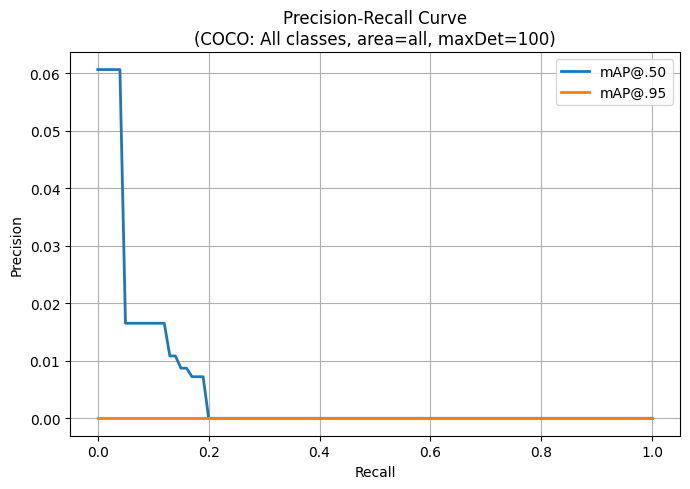

 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.005
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.012
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.042
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.051
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.059


In [10]:
import matplotlib.pyplot as plt
import numpy as np
iou_thresholds = np.around(evaluator.params.iouThrs, 2)  # array of 10 iou thresholds
recall_thresholds = evaluator.params.recThrs  # 101 recall points

# Indices for .50 and .95 IoU
iou50_idx = np.where(iou_thresholds == 0.5)[0][0]
iou95_idx = np.where(iou_thresholds == 0.95)[0][0]

# Average across all classes, area=0 (all), maxDets=2 (100)
pr50 = evaluator.eval['precision'][iou50_idx, :, :, 0, 2].mean(axis=1)
pr95 = evaluator.eval['precision'][iou95_idx, :, :, 0, 2].mean(axis=1)

plt.figure(figsize=(7,5))
plt.plot(recall_thresholds, pr50, label="mAP@.50", lw=2)
plt.plot(recall_thresholds, pr95, label="mAP@.95", lw=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve\n(COCO: All classes, area=all, maxDet=100)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

evaluator.summarize()

In [7]:
evaluator = COCOeval(coco_gt, coco_dt, iouType="bbox")
evaluator.evaluate()
evaluator.accumulate()
evaluator.summarize()


Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.005
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.012
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.042
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.051
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100

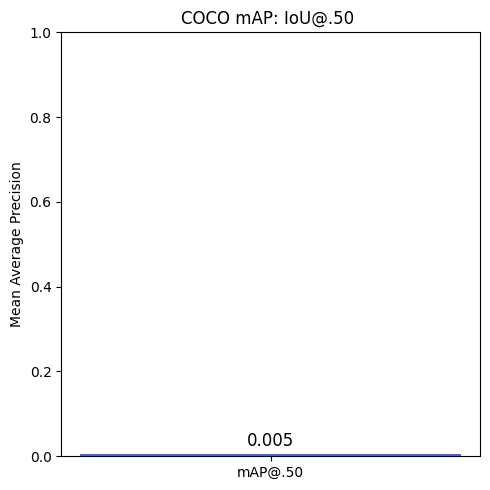

In [12]:
import matplotlib.pyplot as plt

# Get mAP@.50 and mAP@.95 from COCOeval stats
map_50 = evaluator.stats[1]  # AP@.50
map_95 = evaluator.stats[4]  # AP@.95

# Prepare data
x_labels = ["mAP@.50"]
y_values = [map_50]

# Plot
plt.figure(figsize=(5,5))
bars = plt.bar(x_labels, y_values, color=["royalblue", "orange"])
plt.ylim(0, 1)
plt.ylabel("Mean Average Precision")
plt.title("COCO mAP: IoU@.50 ")

# Annotate values
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
             f"{bar.get_height():.3f}", ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()


# RepoStyle - GroundingDino

In [ ]:
# Clone the repo first
!git clone https://github.com/IDEA-Research/GroundingDINO.git

# Change working directory in Python
import os
os.chdir("/content/GroundingDINO")

# Now install the package
!pip install -e .

# Install additional dependencies
!pip install opencv-python pycocotools matplotlib


fatal: destination path 'GroundingDINO' already exists and is not an empty directory.
Obtaining file:///content/GroundingDINO
  Preparing metadata (setup.py) ... done
  Running setup.py develop for groundingdino
    error: subprocess-exited-with-error
    
    × python setup.py develop did not run successfully.
    │ exit code: 1
    ╰─> See above for output.
    
    note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

× python setup.py develop did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [ ]:
!pip install nvidia-cublas-cu12 nvidia-cudnn-cu12 nvidia-cusparse-cu12 nvidia-cusolver-cu12


In [ ]:
%cd GroundingDINO
!python setup.py build develop


/content/GroundingDINO/GroundingDINO
Compiling with CUDA
running build
running build_py
creating build/lib.linux-x86_64-cpython-311/groundingdino
copying groundingdino/version.py -> build/lib.linux-x86_64-cpython-311/groundingdino
copying groundingdino/__init__.py -> build/lib.linux-x86_64-cpython-311/groundingdino
creating build/lib.linux-x86_64-cpython-311/groundingdino/datasets
copying groundingdino/datasets/cocogrounding_eval.py -> build/lib.linux-x86_64-cpython-311/groundingdino/datasets
copying groundingdino/datasets/transforms.py -> build/lib.linux-x86_64-cpython-311/groundingdino/datasets
copying groundingdino/datasets/__init__.py -> build/lib.linux-x86_64-cpython-311/groundingdino/datasets
creating build/lib.linux-x86_64-cpython-311/groundingdino/config
copying groundingdino/config/GroundingDINO_SwinB_cfg.py -> build/lib.linux-x86_64-cpython-311/groundingdino/config
copying groundingdino/config/GroundingDINO_SwinT_OGC.py -> build/lib.linux-x86_64-cpython-311/groundingdino/conf

In [ ]:
import os
import json
import torch
from PIL import Image
from tqdm import tqdm
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from groundingdino.util.inference import load_model, predict
from groundingdino.util.inference import load_image


# ========== CONFIG ==========
ANNOTATIONS_PATH = '/content/drive/MyDrive/cocoann/annotations/instances_default.json'
IMAGE_DIR = '/content/drive/MyDrive/cocoann/images'
OUTPUT_PREDICTIONS = "predictions.json"
MODEL_CONFIG =  config
MODEL_WEIGHTS = pt
TEXT_PROMPT = "graffiti, trash"
BOX_THRESHOLD = 0.3
TEXT_THRESHOLD = 0.25
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ========== LOAD MODEL ==========
print("Loading model...")
model = load_model(MODEL_CONFIG, MODEL_WEIGHTS).to(DEVICE)

# ========== LOAD DATA ==========
print("Loading COCO annotations...")
coco_gt = COCO(ANNOTATIONS_PATH)
categories = coco_gt.loadCats(coco_gt.getCatIds())
category_name_to_id = {cat["name"].lower(): cat["id"] for cat in categories}

# ========== INFERENCE ==========
results = []

print("Running inference...")
for image_info in tqdm(coco_gt.dataset["images"]):
    image_id = image_info["id"]
    image_path = os.path.join(IMAGE_DIR, image_info["file_name"])

    _, image_tensor = load_image(image_path)


    boxes, scores, labels = predict(
        model=model,
        image=image_tensor,
        caption=TEXT_PROMPT,
        box_threshold=BOX_THRESHOLD,
        text_threshold=TEXT_THRESHOLD
    )

    for box, score, label in zip(boxes, scores, labels):
        label_clean = label.strip().lower()
        if label_clean not in category_name_to_id:
            continue  # skip unknown

        x_min, y_min, x_max, y_max = box
        width, height = x_max - x_min, y_max - y_min

        results.append({
            "image_id": image_id,
            "category_id": category_name_to_id[label_clean],
            "bbox": [x_min, y_min, width, height],
            "score": float(score)
        })

# ========== SAVE PREDICTIONS ==========
with open(OUTPUT_PREDICTIONS, "w") as f:
    json.dump(results, f)

# ========== EVALUATE ==========
print("Evaluating with COCO metrics...")
coco_dt = coco_gt.loadRes(OUTPUT_PREDICTIONS)
evaluator = COCOeval(coco_gt, coco_dt, iouType="bbox")
evaluator.evaluate()
evaluator.accumulate()
evaluator.summarize()  # Prints mAP@0.5:0.95 and more


Loading model...
final text_encoder_type: bert-base-uncased
Loading COCO annotations...
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Running inference...


  0%|          | 0/95 [00:00<?, ?it/s]


NameError: name '_C' is not defined

# Working OG Inference Version

In [1]:
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
from PIL import Image
import requests, torch

from google.colab import drive
drive.mount('/content/drive')

# Path to your dataset
test_dataset_path = '/content/drive/MyDrive/cocoann'

dataset_path = '/content/drive/MyDrive/TestDataset'
image1 = '/content/drive/MyDrive/TestDataset/images/000000039769.jpg'
image2 = '/content/drive/MyDrive/graf.jpg'
image2=Image.open(image2)

Mounted at /content/drive


In [2]:
pip install pycocotools tqdm


In [3]:


model_id = "IDEA-Research/grounding-dino-tiny"
device   = "cuda" if torch.cuda.is_available() else "cpu"

processor = AutoProcessor.from_pretrained(model_id)
model     = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)

# Load an image
# img_url = "http://images.cocodataset.org/val2017/000000039769.jpg"
# image   = Image.open(requests.get(img_url, stream=True).raw)

# Define prompts
text_labels = [['Graffiti', 'graffiti letters', 'painted graffiti drawings']]

inputs  = processor(images=image2, text=text_labels, return_tensors="pt").to(device)
outputs = model(**inputs)

results = processor.post_process_grounded_object_detection(
    outputs, inputs.input_ids,
    box_threshold=0.4, text_threshold=0.3,
    target_sizes=[image.size[::-1]]
)




/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/457 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.64k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/689M [00:00<?, ?B/s]

In [4]:
print(results[0].keys())

dict_keys(['scores', 'boxes', 'text_labels', 'labels'])


In [5]:
res = results[0]
boxes       = res['boxes']
scores      = res['scores']
text_labels = res['text_labels']  # these are your actual prompt strings

for box, score, label in zip(boxes, scores, text_labels):
    print(f"Detected {label} at {box.tolist()} (score: {score:.2f})")


Detected graffiti letters at [184.43966674804688, 192.06744384765625, 497.3898620605469, 334.98248291015625] (score: 0.41)


# Testing with LabelDataset

In [ ]:
#import os
import json
import torch
from tqdm import tqdm
from PIL import Image
from transformers import DetrImageProcessor, AutoModelForObjectDetection
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

# ==== Config ====
COCO_ANNOTATION_PATH = "'/content/drive/MyDrive/cocoann/annotations/instances_default.json"
IMAGE_DIR = "content/drive/MyDrive/cocoann/images"
OUTPUT_JSON = "predictions.json"
MODEL_ID = "IDEA-Research/grounding-dino-tiny"
BOX_THRESHOLD = 0.3
TEXT_THRESHOLD = 0.25

# ==== Device ====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==== Load model and processor ====
processor = DetrImageProcessor.from_pretrained(MODEL_ID)
model = AutoModelForObjectDetection.from_pretrained(MODEL_ID).to(device)

# ==== Load COCO GT ====
coco_gt = COCO(COCO_ANNOTATION_PATH)
categories = coco_gt.loadCats(coco_gt.getCatIds())
class_names = [cat["name"] for cat in categories]
category_name_to_id = {cat["name"]: cat["id"] for cat in categories}

# ==== Inference ====
results = []

for image_info in tqdm(coco_gt.dataset["images"], desc="Running inference"):
    image_id = image_info["id"]
    image_path = os.path.join(IMAGE_DIR, image_info["file_name"])
    image = Image.open(image_path).convert("RGB")

    # Preprocess
    inputs = processor(images=image, text=", ".join(class_names), return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    target_sizes = [image.size[::-1]]  # height, width
    results_processed = processor.post_process_grounded_object_detection(
        outputs,
        inputs.input_ids,
        box_threshold=BOX_THRESHOLD,
        text_threshold=TEXT_THRESHOLD,
        target_sizes=target_sizes
    )[0]

    # Format predictions
    for box, label, score in zip(results_processed["boxes"], results_processed["labels"], results_processed["scores"]):
        label_text = processor.tokenizer.decode(label).strip().lower()
        if label_text not in category_name_to_id:
            continue

        category_id = category_name_to_id[label_text]
        x_min, y_min, x_max, y_max = box.tolist()
        width = x_max - x_min
        height = y_max - y_min

        results.append({
            "image_id": image_id,
            "category_id": category_id,
            "bbox": [x_min, y_min, width, height],
            "score": float(score)
        })

# ==== Save predictions ====
with open(OUTPUT_JSON, "w") as f:
    json.dump(results, f)

# ==== Evaluate mAP ====
coco_dt = coco_gt.loadRes(OUTPUT_JSON)
evaluator = COCOeval(coco_gt, coco_dt, iouType="bbox")
evaluator.evaluate()
evaluator.accumulate()
evaluator.summarize()  # mAP metrics printed here


ValueError: Unrecognized configuration class <class 'transformers.models.grounding_dino.configuration_grounding_dino.GroundingDinoConfig'> for this kind of AutoModel: AutoModelForObjectDetection.
Model type should be one of ConditionalDetrConfig, DabDetrConfig, DeformableDetrConfig, DetaConfig, DetrConfig, RTDetrConfig, RTDetrV2Config, TableTransformerConfig, YolosConfig.

In [ ]:
!pip install ultralytics

from ultralytics import YOLO
import glob
import cv2

from google.colab import drive
drive.mount('/content/drive')

# Path to your dataset
dataset_path = '/content/drive/MyDrive/TestDataset'

# Load a YOLO model (e.g., small version)
model = YOLO('yolov8n.pt')  # or 'yolov8s.pt', 'yolov8m.pt' etc.

# Start training
model.train(
    data=f'{dataset_path}/data.yaml',  # path to your data.yaml
    epochs=50,                         # number of epochs
    imgsz=640,                         # image size
    batch=16                           # batch size (adjust if memory issue)
)


metrics = model.val(data='/content/drive/MyDrive/TestDataset/data.yaml')
print(metrics.results_dict)



In [ ]:
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd GroundingDINO
!pip install -e .
!pip install opencv-python pycocotools matplotlib


fatal: destination path 'GroundingDINO' already exists and is not an empty directory.
/content/GroundingDINO
Obtaining file:///content/GroundingDINO
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 67.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.6 MB/s eta 0:00:00
   ━━━━━━